INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


                          card_present cellular     co2  current deployed  \
2019-11-04 00:00:01+00:00        False     True  1524.0    5.511     True   
2019-11-04 00:00:02+00:00         None     True  1109.0    5.981     True   
2019-11-04 00:00:03+00:00         None     True  1217.0      NaN     True   
2019-11-04 00:00:06+00:00        False     True  1584.0      NaN     True   
2019-11-04 00:00:07+00:00         None     True  2272.0    2.547     True   
...                                ...      ...     ...      ...      ...   
2020-01-24 00:15:01+00:00        False     True   967.0      NaN     True   
2020-01-24 00:15:17+00:00        False     True     NaN      NaN     True   
2020-01-24 00:15:33+00:00         True     True   454.0      NaN     True   
2020-01-24 00:16:01+00:00        False     True   964.0      NaN     True   
2020-01-24 00:17:01+00:00        False     True   964.0      NaN     True   

                          event fw_version  humidity           location  \


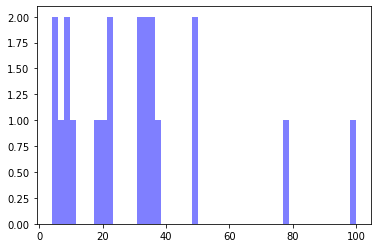

In [39]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L nothing:nothing:nothing aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
LOGGER.info("Done loading data...")


print(data)

print(data.voltage)

x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
num_bins = 50
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()
